In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import get_u_and_eta_from_u_a_and_eta_a as get_u_and_eta
import factor_f_2 as f

# 外皮情報LV0からLV1へのコンバート

## I. 関数

### 1. 規模係数

$$r_{size} = \frac{ A_A }{ A_{S,A} }$$

$r_{size}$: 規模係数  
$A_{A}$: 床面積の合計, m<sup>2</sup>  
$A_{S,A}$: 簡易モデル住宅の床面積の合計, m<sup>2</sup>  

$A_{S,A}$は90.0(m<sup>2</sup>)とする。

In [2]:
def get_r_size(a_a):
    
    a_s_a = 90.0
    
    return a_a / a_s_a

### 2. 主開口方位

主開口方位は南西とする。

In [3]:
def get_direction(angle):
    
    if angle == '0':
        return 'sw'
    elif angle == '90':
        return 'nw'
    elif angle == '180':
        return 'ne'
    elif angle == '270':
        return 'se'
    else:
        return angle

### 3. 一般部位

| 番号 | 部位の種類 | 隣接空間の種類 | 方位 | 床断熱住戸<br>浴室床断熱<br>面積(m2) | 床断熱住戸<br>浴室基礎断熱<br>面積(m2) | 床断熱住戸<br>浴室床なし<br>面積(m2) | 基礎断熱住戸<br>面積(m2) | 熱貫流率(W/m2K) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 屋根又は天井 | 外気             |  上面 | 50.85 | 50.85 | 50.85 | 50.85 | $U_{roof}$        |
| 2 | 壁           | 外気             |   0度 | 30.47 | 30.47 | 30.47 | 30.47 | $U_{wall}$        |
| 3 | 壁           | 外気             |  90度 | 22.37 | 22.37 | 22.37 | 22.37 | $U_{wall}$        |
| 4 | 壁           | 外気             | 180度 | 47.92 | 47.92 | 47.92 | 47.92 | $U_{wall}$        |
| 5 | 壁           | 外気             | 270度 | 22.28 | 22.28 | 22.28 | 22.28 | $U_{wall}$        |
| 6 | 床           | 外気に通じる床裏 |  下面 | 45.05 | 45.05 | 48.36 |  0.00 | $U_{floor,other}$ |
| 7 | 床           | 外気に通じる床裏 |  下面 |  3.31 |  0.00 |  0.00 |  0.00 | $U_{floor,bath}$  |

面積は表の値に規模係数を乗じた値とする。

In [4]:
def get_general_parts(a_a, house_type, u_roof, u_wall, u_floor_other = None, u_floor_bath = None):

    table = [
        [1, 'ceiling',         'outdoor',    'top', {'f_f' : 50.85, 'f_b' : 50.85, 'f_n' : 50.85, 'b' : 50.85},        u_roof ],
        [2,    'wall',         'outdoor',      '0', {'f_f' : 30.47, 'f_b' : 30.47, 'f_n' : 30.47, 'b' : 30.47},        u_wall ],
        [3,    'wall',         'outdoor',     '90', {'f_f' : 22.37, 'f_b' : 22.37, 'f_n' : 22.37, 'b' : 22.37},        u_wall ],
        [4,    'wall',         'outdoor',    '180', {'f_f' : 47.92, 'f_b' : 47.92, 'f_n' : 47.92, 'b' : 47.92},        u_wall ],
        [5,    'wall',         'outdoor',    '270', {'f_f' : 22.28, 'f_b' : 22.28, 'f_n' : 22.28, 'b' : 22.28},        u_wall ],
        [6,   'floor', 'open_underfloor', 'bottom', {'f_f' : 45.05, 'f_b' : 45.05, 'f_n' : 48.36, 'b' :  0.00}, u_floor_other ],
        [7,   'floor', 'open_underfloor', 'bottom', {'f_f' :  3.31, 'f_b' :  0.00, 'f_n' :  0.00, 'b' :  0.00},  u_floor_bath ],
    ]

    parts = []
    
    for row in table:
        
        if row[4][house_type] > 0.0:
            
            parts.append({
                'name'                  : 'simple_general_part' + str(row[0]),
                'general_part_type'     : row[1],
                'next_space'            : row[2],
                'external_surface_type' : {
                    'outdoor'         : 'outdoor',
                    'open_underfloor' : 'not_outdoor'
                }[row[2]],
                'direction'             : get_direction(row[3]),
                'area'                  : row[4][house_type] * get_r_size(a_a),
                'spec' : {
                    'structure'                 : 'wood',
                    'u_value_input_method_wood' : 'u_value_directly',
                    'u_value_wood'              : row[5],
                    'is_sunshade_input'         : False
                }
            })
    
    return parts

#### Example

In [5]:
get_general_parts(a_a=120.0, house_type='f_f', u_roof= 7.7, u_wall= 6.67, u_floor_other=5.27, u_floor_bath=5.27)

[{'name': 'simple_general_part1',
  'general_part_type': 'ceiling',
  'next_space': 'outdoor',
  'external_surface_type': 'outdoor',
  'direction': 'top',
  'area': 67.8,
  'spec': {'structure': 'wood',
   'u_value_input_method_wood': 'u_value_directly',
   'u_value_wood': 7.7,
   'is_sunshade_input': False}},
 {'name': 'simple_general_part2',
  'general_part_type': 'wall',
  'next_space': 'outdoor',
  'external_surface_type': 'outdoor',
  'direction': 'sw',
  'area': 40.626666666666665,
  'spec': {'structure': 'wood',
   'u_value_input_method_wood': 'u_value_directly',
   'u_value_wood': 6.67,
   'is_sunshade_input': False}},
 {'name': 'simple_general_part3',
  'general_part_type': 'wall',
  'next_space': 'outdoor',
  'external_surface_type': 'outdoor',
  'direction': 'nw',
  'area': 29.826666666666668,
  'spec': {'structure': 'wood',
   'u_value_input_method_wood': 'u_value_directly',
   'u_value_wood': 6.67,
   'is_sunshade_input': False}},
 {'name': 'simple_general_part4',
  'gener

### 4. 大部分がガラスで構成される窓等の開口部

#### 1) 壁面からの日除けの張り出し寸法

取得日射熱補正係数を指定する場合

$$
z_H = b_H \frac{c_H y_1 + y_2}{ \frac{f_H}{0.01} - a_H }
$$

ただし、$f_H$が0.72を超える場合は$f_H=0.72$とする。また、$z_H$が5.0を超える場合は$z_H=5.0$とする。

$$
z_C = b_C \frac{c_C y_1 + y_2}{ \frac{f_C}{0.01} - a_C }
$$

ただし、$f_H$が0.93を超える場合は$f_C=0.93$とする。また、$z_C$が5.0を超える場合は$z_C=5.0$とする。

取得日射熱補正係数を指定しない場合

$$ z_H = \frac{ ( y_1 + y_2 ) }{ l_{H,2} } $$

$$z_C=0$$

$z_H$：暖房期の壁面から日除けの張り出し寸法, m  
$z_C$：冷房期の壁面から日除けの張り出し寸法, m  
$f_H$: 暖房期の取得日射熱補正係数  
$f_C$: 冷房期の取得日射熱補正係数  
$y_{1}$：日除け下端から窓上端までの垂直方向の距離, m  
$y_{2}$：窓の開口高さ, m  

$$y_1=0$$

$$y_2=1.1$$

$$l_{H,2}=\frac{1}{0.3}$$

| 季節 | 地域区分 | 方位 | a | b | c |
|:---:|:---:|:---:|:---:|:---:|:---:|
| 暖房期 | 1地域～7地域 | 南東(SE) | 5 | 20 | 3 |
| 暖房期 | 1地域～7地域 | 南西(SW) | 5 | 20 | 3 |
| 暖房期 | 1地域～7地域 | 北西(NW) | 10 | 15 | 2 |
| 暖房期 | 1地域～7地域 | 北東(NE) | 10 | 15 | 2 |

| 季節 | 地域区分 | 方位 | a | b | c |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| 冷房期 | 1地域～7地域 | 南東(SE) | 16 | 24 | 2 |
| 冷房期 | 1地域～7地域 | 南西(SW) | 16 | 24 | 2 |
| 冷房期 | 1地域～7地域 | 北西(NW) | 16 | 24 | 2 |
| 冷房期 | 1地域～7地域 | 北東(NE) | 16 | 24 | 2 |
| 冷房期 | 8地域 | 南東(SE) | 16 | 19 | 2 |
| 冷房期 | 8地域 | 南西(SW) | 16 | 19 | 2 |
| 冷房期 | 8地域 | 北西(NW) | 16 | 24 | 2 |
| 冷房期 | 8地域 | 北東(NE) | 16 | 24 | 2 |

In [6]:
def get_heating_overhang_width(is_f_value_input, region, direction, y1, y2, f=None):

    if is_f_value_input:
        
        if region <= 7:
            a, b, c = {
                'se': ( 5, 20, 3),
                'sw': ( 5, 20, 3),
                'nw': (10, 15, 2),
                'ne': (10, 15, 2)
            }[direction]
        elif region == 8:
            raise ValueError('z_Hを取得する関数で地域が8地域を指定されました。')
        else:
            raise ValueError('z_Hを取得する関数でregionに不正な値が指定されました。')
        
        _f = min(f, 0.72)
        
        if ( ( _f / 0.01 ) - a) <= 0: 
            return 5.0
        else:
            return min( ( b * ( c * y1 + y2) ) / ( ( _f / 0.01 ) - a ), 5.0 )

    else:
        
        l_h_2 = 1 / 0.3
        
        return ( y1 + y2 ) / l_h_2        

In [7]:
def get_cooling_overhang_width(is_f_value_input, region, direction, y1, y2, f=None):

    if is_f_value_input:
        
        if region <= 7:
            a, b, c = {
                'se': (16, 24, 2),
                'sw': (16, 24, 2),
                'nw': (16, 24, 2),
                'ne': (16, 24, 2)
            }[direction]
        elif region == 8:
            a, b, c = {
                'se': (16, 19, 2),
                'sw': (16, 19, 2),
                'nw': (16, 24, 2),
                'ne': (16, 24, 2)
            }[direction]
        else:
            raise ValueError('z_Cを取得する関数でregionに不正な値が指定されました。')
            
        _f = min(f, 0.93)
        
        if ( ( _f / 0.01 ) - a) <= 0: 
            return 5.0
        else:
            return min( ( b * ( c * y1 + y2) ) / ( ( _f / 0.01 ) - a ), 5.0 )
    
    else:
        
        return 0.0

1地域～7地域

$$z=\frac{z_H + z_C}{2}$$

8地域

$$ z = z_C $$

$z$：壁面から日除けの張り出し寸法, m  

In [8]:
def get_y1_y2_z(is_f_value_input, region, direction, f_h=None, f_c=None):
    
    y1, y2 = 0.0, 1.1 
    
    if region == 8:
        z_c = get_cooling_overhang_width(is_f_value_input, region, direction, y1, y2, f_c)
        z = z_c
    else:
        z_h = get_heating_overhang_width(is_f_value_input, region, direction, y1, y2, f_h)
        z_c = get_cooling_overhang_width(is_f_value_input, region, direction, y1, y2, f_c)
        z = ( z_h + z_c ) / 2
        
    return y1, y2, z

#### Example

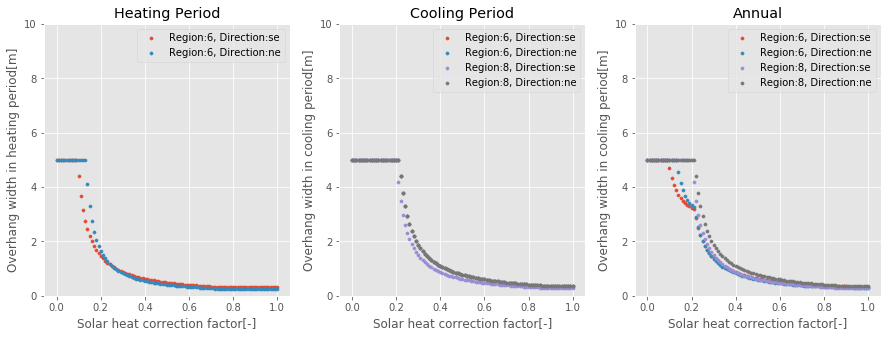

In [9]:
# 取得日射熱補正係数の配列を用意
xs = np.arange( 0.0, 1.01, 0.01 )

windows = [
    {'region': 6, 'direction': 'se'},
    {'region': 6, 'direction': 'ne'},
    {'region': 8, 'direction': 'se'},
    {'region': 8, 'direction': 'ne'}
]

y1, y2 = 0.0, 1.1

fig = plt.figure(figsize = (15, 5))
plt.style.use('ggplot')

# 暖房期 
ax0 = fig.add_subplot(1, 3, 1)
for window in windows:
    if window['region'] >= 8:
        continue
    else:
        z_h = [get_heating_overhang_width(is_f_value_input=True, region=window['region'], direction=window['direction'],
                                          y1=y1, y2=y2, f=f) for f in xs]
        label =  'Region:' + str(window['region']) + ', Direction:' + window['direction']
        ax0.scatter(xs, z_h, 10, label=label)
ax0.set_title('Heating Period')
ax0.set_xlabel('Solar heat correction factor[-]')
ax0.set_ylabel('Overhang width in heating period[m]')
ax0.set_ylim(0,10)
ax0.legend()

# 冷房期
ax1 = fig.add_subplot(1, 3, 2)
for window in windows:
    z_c = [get_cooling_overhang_width(is_f_value_input=True, region=window['region'], direction=window['direction'],
                                      y1=y1, y2=y2, f=f) for f in xs]
    label =  'Region:' + str(window['region']) + ', Direction:' + window['direction']
    ax1.scatter(xs, z_c, 10,label = label)
    
ax1.set_title('Cooling Period')
ax1.set_xlabel('Solar heat correction factor[-]')
ax1.set_ylabel('Overhang width in cooling period[m]')
ax1.set_ylim(0,10)
ax1.legend()

# 通年
ax3 = fig.add_subplot(1,3,3)
for window in windows:
    z = [get_y1_y2_z(is_f_value_input=True, region=window['region'], direction=window['direction'], f_h=f, f_c=f)[2] for f in xs]
    label = 'Region:' + str(window['region']) + ', Direction:' + window['direction']
    ax3.scatter(xs, z, 10, label=label)

ax3.set_title('Annual')
ax3.set_xlabel('Solar heat correction factor[-]')
ax3.set_ylabel('Overhang width in cooling period[m]')
ax3.set_ylim(0,10)
ax3.legend()
    
plt.show()

#### 2) 種類・隣接空間の種類・方位・面積

| 番号 | 隣接空間の種類 | 方位 | 面積(m2) | 熱貫流率(W/m2K) | 暖房期の垂直面日射熱取得率 | 冷房期の垂直面日射熱取得率 |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 外気 |   0度 | 22.69 | $U_{window}$ | $\eta_{d,H}$ | $\eta_{d,C}$ |
| 2 | 外気 |  90度 |  2.38 | $U_{window}$ | $\eta_{d,H}$ | $\eta_{d,C}$ |
| 3 | 外気 | 180度 |  3.63 | $U_{window}$ | $\eta_{d,H}$ | $\eta_{d,C}$ |
| 4 | 外気 | 270度 |  4.37 | $U_{window}$ | $\eta_{d,H}$ | $\eta_{d,C}$ |

面積は表の値に規模係数を乗じた値とする。

$$ \eta_d = \frac{ ( \eta_{d,H} + \eta_{d,C} ) }{ 2 } $$

$ \eta_{d,H} $：暖房期の垂直面日射熱取得率  
$ \eta_{d,C} $：冷房期の垂直面日射熱取得率  
$ \eta_d $：垂直面日射熱取得率  

In [10]:
def get_eta_d(eta_d_h, eta_d_c):
    
    return ( eta_d_h + eta_d_c ) / 2

In [11]:
def get_windows(a_a, region, u_window, eta_d_h, eta_d_c, is_f_value_input, f_h, f_c):

    table = [
        [1, 'outdoor' ,   '0', 22.69, u_window, eta_d_h, eta_d_c],
        [2, 'outdoor' ,  '90',  2.38, u_window, eta_d_h, eta_d_c],
        [3, 'outdoor' , '180',  3.63, u_window, eta_d_h, eta_d_c],
        [4, 'outdoor' , '270',  4.37, u_window, eta_d_h, eta_d_c],
    ]
    
    parts = []
    
    for row in table:
    
        direction = get_direction(row[2])
        y1, y2, z = get_y1_y2_z(is_f_value_input, region, direction, f_h, f_c)
        eta_d = get_eta_d(row[5], row[6])

        parts.append({
            'name'             : 'simple_window_part' + str(row[0]),
            'next_space'       : row[1],
            'direction'        : direction,
            'area'             : row[3] * get_r_size(a_a),
            'spec' : {
                'window_type' : 'single',
                'windows' : [
                    {
                        'u_value_input_method'     : 'u_value_directly',
                        'u_value'                  : row[4],
                        'eta_d_value_input_method' : 'eta_d_value_directly',
                        'eta_d_value'              : eta_d,
                        'glass_type'               : 'single',
                    }
                ],
                'attachment_type'            : 'none',
                'is_windbreak_room_attached' : False,
                'sunshade' : {
                    'y1' : y1,
                    'y2' : y2,
                    'z'  : z,
                }
            }
        })

    return parts

#### Exmaple

In [12]:
get_windows(a_a = 120.0, region = 6, u_window = 3.49, eta_d_h = 0.51, eta_d_c = 0.51, is_f_value_input = True, f_h = 0.7, f_c = 0.9)

[{'name': 'simple_window_part1',
  'next_space': 'outdoor',
  'direction': 'sw',
  'area': 30.253333333333334,
  'spec': {'window_type': 'single',
   'windows': [{'u_value_input_method': 'u_value_directly',
     'u_value': 3.49,
     'eta_d_value_input_method': 'eta_d_value_directly',
     'eta_d_value': 0.51,
     'glass_type': 'single'}],
   'attachment_type': 'none',
   'is_windbreak_room_attached': False,
   'sunshade': {'y1': 0.0, 'y2': 1.1, 'z': 0.34760914760914763}}},
 {'name': 'simple_window_part2',
  'next_space': 'outdoor',
  'direction': 'nw',
  'area': 3.173333333333333,
  'spec': {'window_type': 'single',
   'windows': [{'u_value_input_method': 'u_value_directly',
     'u_value': 3.49,
     'eta_d_value_input_method': 'eta_d_value_directly',
     'eta_d_value': 0.51,
     'glass_type': 'single'}],
   'attachment_type': 'none',
   'is_windbreak_room_attached': False,
   'sunshade': {'y1': 0.0, 'y2': 1.1, 'z': 0.3158783783783784}}},
 {'name': 'simple_window_part3',
  'next_s

### 5. 大部分がガラスで構成されないドア等の開口部

| 番号 | 隣接空間の種類 | 方位 | 面積(m2) | 熱貫流率(W/m2K) |
| --- | --- | --- | --- | --- |
| 1 | 外気 |  90度 | 1.89 | $U_{door}$ |
| 2 | 外気 | 180度 | 1.62 | $U_{door}$ |


面積は表の値に規模係数を乗じた値とする。

In [13]:
def get_doors(a_a, u_door):

    table = [
        [1, 'outdoor',  '90', 1.89, u_door],
        [2, 'outdoor', '180', 1.62, u_door],
    ]
    
    parts = []
    
    for row in table:
    
        direction = get_direction(row[2])

        parts.append({
            'name'       : 'simple_door_part' + str(row[0]),
            'next_space' : row[1],
            'direction'  : direction,
            'area'       : row[3] * get_r_size(a_a),
            'spec'       : {
                'u_value'           : row[4],
                'is_sunshade_input' : False,
            }
        })

    return parts

#### Example

In [14]:
get_doors(a_a = 120.0, u_door = 2.33)

[{'name': 'simple_door_part1',
  'next_space': 'outdoor',
  'direction': 'nw',
  'area': 2.5199999999999996,
  'spec': {'u_value': 2.33, 'is_sunshade_input': False}},
 {'name': 'simple_door_part2',
  'next_space': 'outdoor',
  'direction': 'ne',
  'area': 2.16,
  'spec': {'u_value': 2.33, 'is_sunshade_input': False}}]

### 6. 土間床等の外周部

| 番号 | 隣接空間の種類 | 方位<br>（参考） | 床断熱住戸<br>浴室床断熱<br>面積(m) | 床断熱住戸<br>浴室基礎断熱<br>長さ(m) | 床断熱住戸<br>浴室床なし<br>長さ(m) | 基礎断熱住戸<br>長さ(m) | 線熱貫流率(W/mK) |
| --- | --- | --- | --- | --- | --- | --- | --- |
|  1 | 外気             |  90度 |  1.82 |  1.82 |  1.82 |  1.82 | $\psi_{prm,etrc}$  |
|  2 | 外気             | 180度 |  1.37 |  1.37 |  1.37 |  1.37 | $\psi_{prm,etrc}$  |
|  3 | 外気に通じる床裏 |     - |  3.19 |  3.19 |  3.19 |  0.00 | $\psi_{prm,etrc}$  |
|  4 | 外気             |  90度 |  0.00 |  1.82 |  0.00 |  1.82 | $\psi_{prm,bath}$  |
|  5 | 外気             | 180度 |  0.00 |  1.82 |  0.00 |  1.82 | $\psi_{prm,bath}$  |
|  6 | 外気に通じる床裏 |     - |  0.00 |  3.64 |  0.00 |  0.00 | $\psi_{prm,bath}$  |
|  7 | 外気             |   0度 |  0.00 |  0.00 |  0.00 | 10.61 | $\psi_{prm,other}$ |
|  8 | 外気             |  90度 |  0.00 |  0.00 |  0.00 |  1.15 | $\psi_{prm,other}$ |
|  9 | 外気             | 180度 |  0.00 |  0.00 |  0.00 |  7.42 | $\psi_{prm,other}$ |
| 10 | 外気             | 270度 |  0.00 |  0.00 |  0.00 |  4.79 | $\psi_{prm,other}$ |

面積は表の値に規模係数を乗じた値とする。

In [15]:
def get_earthfloor_perimeters(a_a, house_type, psi_prm_etrc, psi_prm_bath=None, psi_prm_other=None):

    table = [
        [  1,         'outdoor',    '90', {'f_f' : 1.82, 'f_b' : 1.82, 'f_n' : 1.82, 'b' :  1.82}, psi_prm_etrc ],
        [  2,         'outdoor',   '180', {'f_f' : 1.37, 'f_b' : 1.37, 'f_n' : 1.37, 'b' :  1.37}, psi_prm_etrc ],
        [  3, 'open_underfloor', 'other', {'f_f' : 3.19, 'f_b' : 3.19, 'f_n' : 3.19, 'b' :  0.00}, psi_prm_etrc ],
        [  4,         'outdoor',    '90', {'f_f' : 0.00, 'f_b' : 1.82, 'f_n' : 0.00, 'b' :  1.82}, psi_prm_bath ],
        [  5,         'outdoor',   '180', {'f_f' : 0.00, 'f_b' : 1.82, 'f_n' : 0.00, 'b' :  1.82}, psi_prm_bath ],
        [  6, 'open_underfloor', 'other', {'f_f' : 0.00, 'f_b' : 3.64, 'f_n' : 0.00, 'b' :  0.00}, psi_prm_bath ],
        [  7,         'outdoor',     '0', {'f_f' : 0.00, 'f_b' : 0.00, 'f_n' : 0.00, 'b' : 10.61}, psi_prm_other ],
        [  8,         'outdoor',    '90', {'f_f' : 0.00, 'f_b' : 0.00, 'f_n' : 0.00, 'b' :  1.15}, psi_prm_other ],
        [  9,         'outdoor',   '180', {'f_f' : 0.00, 'f_b' : 0.00, 'f_n' : 0.00, 'b' :  7.42}, psi_prm_other ],
        [ 10,         'outdoor',   '270', {'f_f' : 0.00, 'f_b' : 0.00, 'f_n' : 0.00, 'b' :  4.79}, psi_prm_other ],
    ]

    parts = []
    
    num = 0
    
    for row in table:
        
        if row[3][house_type] > 0.0:
            
            parts.append({
                'name'       : 'simple_earthfloor_perimeter' + str(row[0]),
                'next_space' : row[1],
                'direction'  : get_direction(row[2]),
                'length'     : row[3][house_type] * get_r_size(a_a),
                'spec'       : {
                    'psi_value'  : row[4],
                }
            })
    
    return parts

#### Example

In [16]:
get_earthfloor_perimeters(a_a = 120.0, house_type = 'f_b', psi_prm_etrc = 1.8, psi_prm_bath = 1.8, psi_prm_other = 1.8)

[{'name': 'simple_earthfloor_perimeter1',
  'next_space': 'outdoor',
  'direction': 'nw',
  'length': 2.4266666666666667,
  'spec': {'psi_value': 1.8}},
 {'name': 'simple_earthfloor_perimeter2',
  'next_space': 'outdoor',
  'direction': 'ne',
  'length': 1.8266666666666667,
  'spec': {'psi_value': 1.8}},
 {'name': 'simple_earthfloor_perimeter3',
  'next_space': 'open_underfloor',
  'direction': 'other',
  'length': 4.253333333333333,
  'spec': {'psi_value': 1.8}},
 {'name': 'simple_earthfloor_perimeter4',
  'next_space': 'outdoor',
  'direction': 'nw',
  'length': 2.4266666666666667,
  'spec': {'psi_value': 1.8}},
 {'name': 'simple_earthfloor_perimeter5',
  'next_space': 'outdoor',
  'direction': 'ne',
  'length': 2.4266666666666667,
  'spec': {'psi_value': 1.8}},
 {'name': 'simple_earthfloor_perimeter6',
  'next_space': 'open_underfloor',
  'direction': 'other',
  'length': 4.8533333333333335,
  'spec': {'psi_value': 1.8}}]

### 7. 土間床等

| 番号 | 床断熱住戸<br>浴室床断熱<br>面積(m2) | 床断熱住戸<br>浴室基礎断熱<br>長さ(m2) | 床断熱住戸<br>浴室床なし<br>長さ(m2) | 基礎断熱住戸<br>長さ(m2) |
| --- | --- | --- | --- | --- |
|  1 | 2.48 | 2.48 | 2.48 |  2.48 |
|  2 | 0.00 | 3.31 | 0.00 |  3.31 |
|  3 | 0.00 | 0.00 | 0.00 | 45.05 |

面積は表の値に規模係数を乗じた値とする。

In [17]:
def get_earthfloor_centers(a_a, house_type):

    table = [
        [1, {'f_f' : 2.48, 'f_b' : 2.48, 'f_n' : 2.48, 'b' :  2.48} ],
        [2, {'f_f' : 0.00, 'f_b' : 3.31, 'f_n' : 0.00, 'b' :  3.31} ],
        [3, {'f_f' : 0.00, 'f_b' : 0.00, 'f_n' : 0.00, 'b' : 45.05} ],
    ]

    parts = []
    
    for row in table:
        
        if row[1][house_type] > 0.0:
            
            parts.append({
                'name' : 'simple_earthfloor_center' + str(row[0]),
                'area' : row[1][house_type] * get_r_size(a_a),
            })
    
    return parts

#### Example

In [18]:
get_earthfloor_centers(a_a=120.0, house_type='f_b')

[{'name': 'simple_earthfloor_center1', 'area': 3.3066666666666666},
 {'name': 'simple_earthfloor_center2', 'area': 4.413333333333333}]

In [19]:
def get_house_type(insulation_type, insulation_type_bathroom):
    
    if insulation_type == 'floor':
        if insulation_type_bathroom == 'floor':
            return 'f_f'
        elif insulation_type_bathroom == 'base':
            return 'f_b'
        elif insulation_type_bathroom == 'inside':
            return 'f_n'
        else:
            raise Exception('床断熱住戸における浴室の断熱の種類を指定するkeyが間違っています。')
    elif insulation_type == 'base':
        return 'b'
    else:
        raise Exception('住戸の種類を指定するkeyが間違っています。')

## II. 統合

In [20]:
def convert(d):

    common = d['common']
    total_floor_area = common['total_floor_area']
    a_a = common['total_floor_area']
    region = common['region']
    
    envelope = d['envelope']
    
    # 床断熱住戸、浴室は断熱区画内とする
    house_type =get_house_type('floor', 'inside')

    # 共通要素はそのまま保持する
    d_common = copy.deepcopy(d['common'])
    
    u_roof, u_wall, u_floor_other, u_floor_bath, u_window, u_door = None, None, None, None, None, None
    eta_d_h, eta_d_c = 1, 1
    is_f_value_input = False
    f_h, f_c = None, None
    psi_prm_etrc, psi_prm_other, psi_prm_bath = None, None, None
    
    general_parts = get_general_parts(a_a, house_type, u_roof, u_wall, u_floor_other, u_floor_bath)
    windows = get_windows(a_a, region, u_window, eta_d_h, eta_d_c, is_f_value_input, f_h, f_c)
    doors = get_doors(a_a, u_door)
    earthfloor_perimeters = get_earthfloor_perimeters(a_a, house_type, psi_prm_etrc, psi_prm_bath, psi_prm_other)
    earthfloor_centers = get_earthfloor_centers(a_a, house_type)
    
    
    # U値、η値の取得    
    l_direction_s = ['top', 'n', 'ne', 'e', 'se', 's', 'sw', 'w', 'nw']
    
    f_heating = min(f.get_f('heating', d['common']['region'],direction) for direction in l_direction_s)
    f_cooling = max(f.get_f('cooling', d['common']['region'],direction) for direction in l_direction_s)
    
    d_for_u_and_eta = {
        'common':d['common'],
        'envelope':{
            'index': d['envelope']['index'],
            'general_parts': general_parts,
            'windows': windows,
            'doors': doors,
            'earthfloor_perimeters': earthfloor_perimeters,
            'earthfloor_centers': earthfloor_centers
        }
    }
    
    eta, eta_heating, eta_cooling, part_U = get_u_and_eta.calc_adjustment_factor( d_for_u_and_eta )
    
    return {
        'common' : copy.deepcopy(d['common']),
        'envelope' : {
            'simple_method' : {
                'insulation_type' : 'floor',
                'insulation_type_bathroom' : 'inside',
                'u_value_roof'        : part_U['roof'],
                'u_value_wall'        : part_U['wall'],
                'u_value_floor_other' : part_U['floor'],
                'u_value_door'        : part_U['window'],
                'u_value_window'      : part_U['window'],
                'eta_d_value_window_c' : eta_cooling,       
                'eta_d_value_window_h' : eta_heating, 
                'is_f_value_input' : False, 
                'f_value_c' : f_cooling,
                'f_value_h' : f_heating,
                'psi_value_earthfloor_perimeter_entrance' : part_U['earthfloor_perimeter']
            }
        }
    }

### Example

In [21]:
# commonにhouse_type追加する！！！！！

d = {
    'common' : {
        'region' : 6,
        'house_type' : 'detached',
        'main_occupant_room_floor_area': 30.0,
        'other_occupant_room_floor_area': 30.0,
        'total_floor_area': 90.0
    },
    'envelope' : {
        'input_method' : 'index',
        'index' :{
            'u_a' : 0.87,
            'eta_a_h': 2.8,
            'eta_a_c': 1.4
        }
    }
}

convert(d)

U値{'roof': 0.20174395772715983, 'ceiling': 0.20174395772715983, 'wall': 0.445517906647478, 'floor': 0.4034879154543204, 'window': 3.9087891809637223, 'door': 3.9087891809637223, 'earthfloor_perimeter': 0.6388558661360073},開口部η0.22494713216779566,開口部ηH0.3679210611053846,開口部ηC0.22494713216779566
UA計算値0.87,ηAH計算値2.8000000000000003,ηAC計算値1.4


{'common': {'region': 6,
  'house_type': 'detached',
  'main_occupant_room_floor_area': 30.0,
  'other_occupant_room_floor_area': 30.0,
  'total_floor_area': 90.0},
 'envelope': {'simple_method': {'insulation_type': 'floor',
   'insulation_type_bathroom': 'inside',
   'u_value_roof': 0.20174395772715983,
   'u_value_wall': 0.445517906647478,
   'u_value_floor_other': 0.4034879154543204,
   'u_value_door': 3.9087891809637223,
   'u_value_window': 3.9087891809637223,
   'eta_d_value_window_c': 0.22494713216779566,
   'eta_d_value_window_h': 0.3679210611053846,
   'is_f_value_input': False,
   'f_value_c': 1.0,
   'f_value_h': 0.655,
   'psi_value_earthfloor_perimeter_entrance': 0.6388558661360073}}}